# Модель предсказания веса черепах



В этом проекте мы предлагаем решение задачи определения веса морских черепах по различным параметрам тела животного, таким как характеристики колец на панцире, размеры панциря и других частей тела.

## Постановка задачи машинного обучения

- Опишите, какую задачу нужно решить: регрессии или классификации.
- Выберите поле, которое станет целевой переменной.
- Назовите метрики качества модели, которые планируете использовать.
- Опишите критерии успешности проекта с опорой на метрики.

В данной работе мы решаем задачу регрессии, предсказывая по числовым признакам вес черепахи в килограммах. Будем решать задачу с помощтю обучения с учителем (supervised learning): в датасете имеется целевая переменная - weight, вес черепахи заранее известный для определенных особей, благодаря команде зоологов, изучающих и измеряющих животных.

Целевой метрикой качества модели, по которой будет производится приемка, выступает средняя абсолютная ошибка (MAE) веса черепахи, которая не должна превышать 5 кг для того, чтобы признать модель пригодной для использования. Вспомогательные метрики - MSE, R², MAPE (MSE - для учета вклада больших ошибок, MAPE для учета маленьких и больших черепах, R²/коэффициент детерминации - для оценки доли изменений в целевой переменной, объясняемых изменениями в признаках).



## Подключение и настройка библиотек

В блоке кода ниже, помимо уже указанных библиотек, импортируйте все остальные, которые планируете использовать для проекта.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from phik import phik_matrix
from sklearn.linear_model import Ridge, Lasso, SGDRegressor, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

import requests

## Загрузка датасета

- Загрузите данные из файла `turtles.csv`, путь к файлу: `'/datasets/turtles.csv'`. При использовании метода [read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) установите правильные значения для параметров `sep` и `decimal`: в качестве разделителя столбцов используйте символ табуляции (`'\t'`), а в качестве разделителя дробной части — запятую.
- Проверьте, правильно ли прошла загрузка. Данные должны соответствовать описанию в тексте урока.
- С помощью методов библиотеки pandas выведите общие сведения о данных.
- Возможно ли продолжать работу? Если нет — что нужно сделать, чтобы устранить препятствия?

Загрузим данные, если они отсутствуют в репозитории.

In [2]:
local_dataset_file = 'datasets/turtles.csv'
remote_dataset_url = 'https://code.s3.yandex.net/datasets/turtles.csv'
def read_dataset_csv():
    return pd.read_csv(local_dataset_file, sep='\t', decimal=',')

try:
    df = read_dataset_csv()
except FileNotFoundError:
    print(f'Файл не найден. Загружаем файл в {local_dataset_file} из {remote_dataset_url}')
    response = requests.get(remote_dataset_url)
    if response.status_code == 200:
        with open(local_dataset_file, 'wb') as f:
            f.write(response.content)
        df = read_dataset_csv()
        print(f'Файл с датасетом успешно загружен в {local_dataset_file}')
    else:
        print(f'Ошибка при загрузке файла: {response.status_code}')


Данные успешно загружены в датафрейм. Выведем общую информацию о датасете и несколько строк.

In [3]:
df.head(5)

,id,binomial_name,registration number,shell_length,shell_width,head_length,head_width,flipper_length_1,flipper_width_1,flipper_length_2,flipper_width_2,flipper_length_3,flipper_width_3,flipper_length_4,flipper_width_4,circle_count,measure_count,shell_crack,timestamp,weight
0,20438,Caretta caretta,d89af72662f49ece4d09dec75a8b0166,700.0,381,112.0,82.0,356,205,331,185,270.0,180.0,273.0,144.0,63,3.0,NaN,1703159226,87.687
1,19034,Lepidochelys olivacea,1579c64777de4db1c16e8b7b0d19c45e,341.0,295,65.0,48.0,216,190,229,186,164.0,182.0,180.0,149.0,0,1.0,1.0,1689428175,26.949
2,24689,LEPIDOCHELYS OLIVACEA,bfcec01187569615087e4d777c44985a,408.0,343,71.0,70.0,308,224,285,232,264.0,179.0,268.0,176.0,0,3.0,NaN,1745783111,30.016
3,17945,Lepidochelys Olivacea,2c159675aa28f0ea566fce2090bf4c82,512.0,432,98.0,95.0,334,317,364,284,NaN,NaN,NaN,NaN,3,4.0,1.0,1677757151,33.917
4,24543,lepidochelys olivacea,ecd22499761e2ac56a6d8eb765ec566d,408.0,307,50.0,54.0,280,168,269,218,199.0,165.0,209.0,180.0,0,4.0,1.0,1744455613,28.511


Данныые соответствуют предоставленному описанию датасета и содержат следующие столбцы:
- id - идентификатор измерения
- binomial_name - назчение вида черепахи
- registration number - регистрационный номер черепахи
- shell_length - длина панциря в мм
- shell_width - ширина панциря в мм
- head_length - длина головы в мм
- head_width - ширина головы в мм
- flipper_length_[1..4] - длина плавника с номерами от 1 до 4
- flipper_width_[1..4] - ширина плавника с номерами от 1 до 4
- circle_count - количество колец роста на панцире
- measure_count - количество измерений для получения среднего значения
- shell_crack - флаг наличия или отсутствия трещин в панцире
- timestamp - время внесения данных о черепахе
- weight - вес черепахи

Всего 20 столбцов, незначемые из которых составляют следующий список:
- id
- binomial_name
- registration number
- measure_count
- timestamp

Они не влияют на таргет, поэтому их можно выбросить, но оставим до исследования дубликатов, возможно они дадут дополнительную информацию для процесса очистки данных.

Для удобства переименуем столбец `registration number` в `registration_number`.

In [4]:
df.rename(columns={'registration number': 'registration_number'}, inplace=True)

Теперь посмотрим на типы столбцов датасета:

In [5]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 8861 entries, 0 to 8860
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   8861 non-null   int64  
 1   binomial_name        8812 non-null   str    
 2   registration_number  8832 non-null   str    
 3   shell_length         8774 non-null   float64
 4   shell_width          8861 non-null   int64  
 5   head_length          8715 non-null   float64
 6   head_width           8715 non-null   float64
 7   flipper_length_1     8861 non-null   int64  
 8   flipper_width_1      8861 non-null   int64  
 9   flipper_length_2     8861 non-null   int64  
 10  flipper_width_2      8861 non-null   int64  
 11  flipper_length_3     8760 non-null   float64
 12  flipper_width_3      8760 non-null   float64
 13  flipper_length_4     8760 non-null   float64
 14  flipper_width_4      8760 non-null   float64
 15  circle_count         8861 non-null   int64  
 16 

In [6]:
round((df.isna().sum()/df.shape[0])*100, 2).sort_values(ascending=False)

shell_crack            75.44
measure_count           2.98
head_length             1.65
head_width              1.65
flipper_width_4         1.14
flipper_length_3        1.14
flipper_width_3         1.14
flipper_length_4        1.14
shell_length            0.98
binomial_name           0.55
registration_number     0.33
weight                  0.21
timestamp               0.00
circle_count            0.00
id                      0.00
flipper_length_2        0.00
flipper_width_1         0.00
flipper_length_1        0.00
shell_width             0.00
flipper_width_2         0.00
dtype: float64

Всего в датасете 8861 строк. 
Целевая переменная weight задана только для 8842 строк, соответственно можно сразу удалить строки без целевой переменной, так как они не будут использованы для обучения модели.

Есть незначительное количество пропусков почти во всех столбцах, кроме:
- размеров плавников с номерами 1, 2 (тип столбцов int64)
- circle_count (тип столбца int64)
- shell_width (тип столбца int64)

В столбцах с размерами плавников 1% пропусков. Если плавники с номерами 1 и 2 это передний и задний плавники, то можно восстановить пропущенные значения для плавников с номерами 3 и 4, так как животные как правило имеют примерно одинаковые размеры органов вдоль оси симметрии.

В колонке shell_crack значительное количество пропусков (75%), но это может быть связано с тем, что пропуск является признаком того, что трещины не обнаружены.

В столбцах со значениями размеров головы присутствует 2% пропусков. Их, к сожалению, просто восстановить не получится, поэтому в датасете останется только 8715 строк с заполненными значениями этого признака, остальные придется удалить.

Размерности типов столбцов можно уменьшить до 32-разрядных значений, но в виду небольшого размера датасета, это представляется нецелесообразным. Кроме того, из практики применения pandas было замечено, что при достчете mean-значений, библиотека использует для накопления суммы значений тот же тип, что и агрегируемый столбец, что может приводить к переполнению типа.

### Вывод по разделу загрузки данных

Загрузка произведена успешно, файл сохранен в локальный репозиторий. Датасет соответствует описанию и содержит 8861 запись о размерах черепах. Данные представлены 20 столбцами, 5 из которых представляют незначимые признаки для обучения модели (идентификаторы и прочая), 14 представляют различные характеристики черепах. Целевая переменная присутствует для 99.8% записей. Данных для обучения достаточно.
В большинсве колонок есть незначительные пропуски (около 1%). Столбец shell_crack долей пропусков в 75% может быть интерпретирована так, что пропуски являются признаком отсутствия трещин на панцире черепахи. 

## Исследовательский анализ данных

Проведите исследовательский анализ данных:
1. Выясните, данные о каких черепахах представлены в датасете.
2. Проведите отбор записей о нужном виде черепах. Для дальнейшей работы достаточно изучить только *Chelonia mydas*. При этом вы можете сравнить распределение данных об этих черепахах с другими видами, если есть желание и время.
3. Определите, все ли признаки можно использовать для решения задачи. Ответ обоснуйте. Удалите признаки, которые вам никак не помогут.
4. Проверьте, есть ли в данных пропуски. Определите, какие из них можно обработать сразу, а в каких случаях лучше сперва провести разделение на выборки. Решите, стоит ли удалить некоторые пропуски.
5. Определите, есть ли в данных дубликаты. Выберите корректный способ их обработки.
6. Проанализируйте распределение признаков, постройте необходимые для этого визуализации: ящики с усами, гистограммы и так далее. Определите, есть ли в данных выбросы и какие из них критичные. Решите, можно ли их сразу исправить.
7. Проверьте, одинаков ли масштаб признаков. Если он различается, предложите решение этой проблемы.
8. Проанализируйте корреляцию между признаками и целевой переменной с помощью вычислений и графически. Определите, все ли признаки нужны для дальнейшей работы.
9. Проверьте данные на мультиколлинеарность и решите, можно ли её устранить.

Исследуем, данные о каких черепахах представлены в датасете:

In [7]:
df['binomial_name'].value_counts()

binomial_name
Lepidochelys olivacea     3372
Chelonia mydas            2325
Caretta caretta            674
lepidochelys olivacea      416
Dermochelys coriacea       399
Eretmochelys imbricata     332
Lepidochelys Olivacea      285
chelonia mydas             252
Chelonia Mydas             177
LEPIDOCHELYS OLIVACEA      142
caretta caretta             90
CHELONIA MYDAS              75
Caretta Caretta             46
eretmochelys imbricata      41
dermochelys coriacea        40
CARETTA CARETTA             37
Eretmochelys Imbricata      28
Dermochelys Coriacea        27
Lepidochelys kempii         22
DERMOCHELYS CORIACEA        18
ERETMOCHELYS IMBRICATA       8
lepidochelys kempii          3
Lepidochelys Kempii          3
Name: count, dtype: int64

Из вывода видно, что названия черепах требуют нормализации. Выполним ее:

In [8]:
df['binomial_name'] = df['binomial_name'].str.lower()
df['binomial_name'].value_counts()

binomial_name
lepidochelys olivacea     4215
chelonia mydas            2829
caretta caretta            847
dermochelys coriacea       484
eretmochelys imbricata     409
lepidochelys kempii         28
Name: count, dtype: int64

В датасете представлена информация о 6 видах черепах. Интересующий нас вид `chelonia mydas` содержится в количестве 2829 записей в датасете.
Выберем для дальнейшего исследования выборку по исследуемому виду, предварительно сохранив оригинальный датасет.

In [9]:
# Сохраняем полный датасет до выделения выборки под исследование конкретного вида черепах
df_orig = df.copy()

In [10]:
# оставляем в датасете только интересующий нас вид
df = df[df['binomial_name'] == 'chelonia mydas']

# оценим характеристики датасета:
print(df.info())

<class 'pandas.DataFrame'>
Index: 2829 entries, 8 to 8859
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   2829 non-null   int64  
 1   binomial_name        2829 non-null   str    
 2   registration_number  2825 non-null   str    
 3   shell_length         2794 non-null   float64
 4   shell_width          2829 non-null   int64  
 5   head_length          2790 non-null   float64
 6   head_width           2790 non-null   float64
 7   flipper_length_1     2829 non-null   int64  
 8   flipper_width_1      2829 non-null   int64  
 9   flipper_length_2     2829 non-null   int64  
 10  flipper_width_2      2829 non-null   int64  
 11  flipper_length_3     2798 non-null   float64
 12  flipper_width_3      2798 non-null   float64
 13  flipper_length_4     2798 non-null   float64
 14  flipper_width_4      2798 non-null   float64
 15  circle_count         2829 non-null   int64  
 16  meas

### Обработка пропущенных значений

Вычислим, как распределены пропущенные значения в разных колонках.


In [11]:
round((df.isna().sum()/df.shape[0])*100, 2).sort_values(ascending=False)

shell_crack            76.07
measure_count           2.86
head_length             1.38
head_width              1.38
shell_length            1.24
flipper_length_4        1.10
flipper_width_4         1.10
flipper_length_3        1.10
flipper_width_3         1.10
registration_number     0.14
weight                  0.11
timestamp               0.00
circle_count            0.00
id                      0.00
binomial_name           0.00
flipper_length_2        0.00
flipper_width_1         0.00
flipper_length_1        0.00
shell_width             0.00
flipper_width_2         0.00
dtype: float64

В полученном датасете для целевого вида черепах содержится 2829 записей. Распределение долей пустых значений в столбцах сохраняется с тем, что присутствовали в выводе по исходному датасету - значимые столбцы имеют пропуски примерно в 1% записей, что несущественно для исследования за исключением столбца shell_crack с долей пропусков 76%, которую мы будем интерпретировать как отсутствие трещин на панцире. Аналогичном можно поступить со столбцов measure_count - пропуск можно считать равным значению 1, но заметим, что это незначимые данные для обучения модели. Данных достаточно для обучения модели линейной регрессии. Указанные пропуски лучше обработать до разделения датасетов. Остальные пропуски - исключить из датасета в виду их малого количества.

Избавимся от пропусков в значимых столбцах таблицы.

In [12]:
# сохраним оригинальный датасет с видом черепахи chelonia mydas для сравнения
df_mydas_orig = df.copy()

In [13]:
df.dropna(subset=[
    'head_length',
    'head_width',
    'shell_length',
    'flipper_length_4',
    'flipper_width_4',
    'flipper_length_3',
    'flipper_width_3',
    'weight',
], inplace=True)

df_diff_no_na = len(df_mydas_orig) - len(df)
print(
    f'Удалено строк с пропусками в значимых столбцах: {df_diff_no_na}',
    f'({round(df_diff_no_na/len(df_mydas_orig)*100, 2)}%)'
)

Удалено строк с пропусками в значимых столбцах: 105 (3.71%)


Удалено около 100 строк с пропусками, что составляет 4% от датасета с изучаемым видом черепахи.

Теперь обработаем пропуски в колонке shell_crack (76%), исходя из предположения, что пропуск эквивалентен отсутствию трещин на панцире, то есть может быть заменен значением 0.

Для начала проверим, какие значения есть в данном столбце:

In [14]:
df['shell_crack'].value_counts(dropna=False)

shell_crack
NaN    2073
1.0     429
2.0      85
3.0      62
5.0      53
4.0      22
Name: count, dtype: int64

В столбце встречаются  значения 1..5 и NaN. То есть можно предположить, что значение является не флагом, а указывает на количество трещин на панцире черепахи. Заменим все пустые значения нулями.

In [15]:
# замена пропусков
df['shell_crack'] = df['shell_crack'].fillna(0)

# контроль пропусков в получившемся датасете
df.isna().sum()

id                      0
binomial_name           0
registration_number     4
shell_length            0
shell_width             0
head_length             0
head_width              0
flipper_length_1        0
flipper_width_1         0
flipper_length_2        0
flipper_width_2         0
flipper_length_3        0
flipper_width_3         0
flipper_length_4        0
flipper_width_4         0
circle_count            0
measure_count          80
shell_crack             0
timestamp               0
weight                  0
dtype: int64

Видно, что пропуски остались только в незначимых столбцах.

### Работа с дубликатами

Определим, есть ли в данных явные дубликаты.

In [16]:
len_before = df.shape[0]
df.drop_duplicates(keep='first', inplace=True)
removed_dup_count = len_before - df.shape[0]
print(
    f'Количество удаленных ЯВНЫХ дубликатов {removed_dup_count}',
    f'({round(removed_dup_count/df.shape[0]*100, 2)}%)'
)

Количество удаленных ЯВНЫХ дубликатов 328 (13.69%)


Из датасета удалено 14% строк (~300 шт), которые являются явными полными дубликатами.

Проверим датасет на наличие неявных дубликатов. Перед этим нормализуем строковые столбцы.

In [17]:
# нормализация строковых столбцов
df['registration_number'] = df['registration_number'].str.lower()

In [18]:
find_dups_subsets = [
    ['id'],
    ['registration_number'],
    ['shell_length', 'shell_width', 'head_length', 'head_width'],
    [
        'flipper_length_1',
        'flipper_width_1',
        'flipper_length_2',
        'flipper_width_2',
        'flipper_length_3',
        'flipper_width_3',
        'flipper_length_4',
        'flipper_width_4',
    ],
]

true_dup_subsets = []
for subset in find_dups_subsets:
    dup_count = df[df.duplicated(subset=subset, keep=False)].shape[0]
    print(f'Количество дубликатов {dup_count} по подмножеству {subset}')
    if dup_count > 0:
        true_dup_subsets.append(subset)

Количество дубликатов 0 по подмножеству ['id']
Количество дубликатов 4 по подмножеству ['registration_number']
Количество дубликатов 0 по подмножеству ['shell_length', 'shell_width', 'head_length', 'head_width']
Количество дубликатов 0 по подмножеству ['flipper_length_1', 'flipper_width_1', 'flipper_length_2', 'flipper_width_2', 'flipper_length_3', 'flipper_width_3', 'flipper_length_4', 'flipper_width_4']


Как видно из вывода алгоритма мы имеем дело с небольшим количеством дубликатов по столбцу registration_number, которые можно удалить. Важным фактом является то, что по подмножеству столбцов с основными размерами черепахи `['shell_length', 'shell_width', 'head_length', 'head_width']` дубликатов не обнаружено.

In [19]:
# удалим дубликаты по registration_number
len_before = len(df)
df.drop_duplicates(subset=['registration_number'], keep='first', inplace=True)
diff_len = len_before - len(df)
print(f'Удалено {diff_len} строк ({round(diff_len/len(df_mydas_orig)*100, 2)}%)')

Удалено 3 строк (0.11%)


### Распределение признаков

Проанализируем распределение признаков и визуализируем результат, чтобы определить наличие выбросов и способ их обработки.

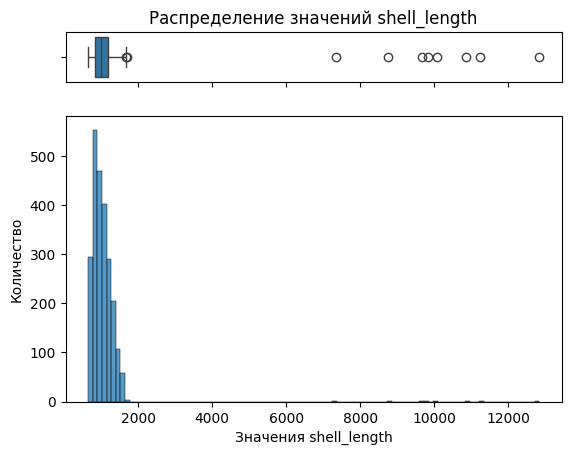

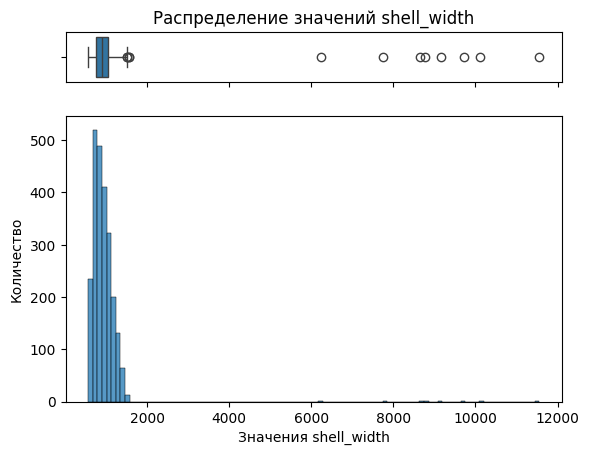

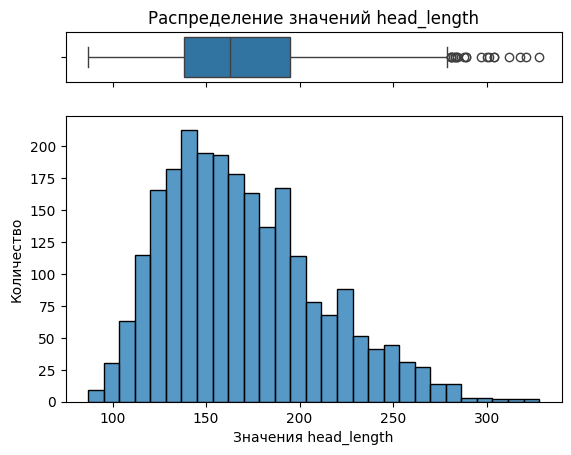

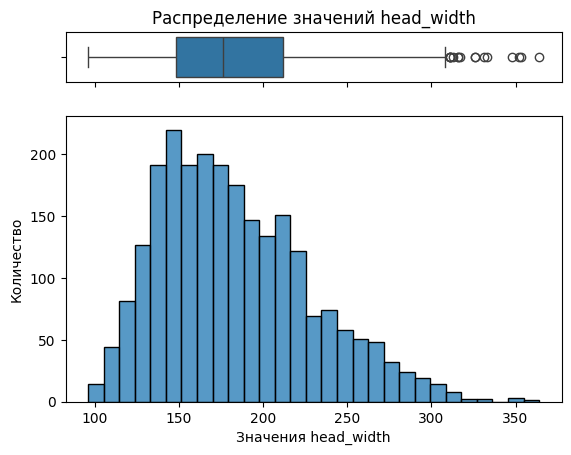

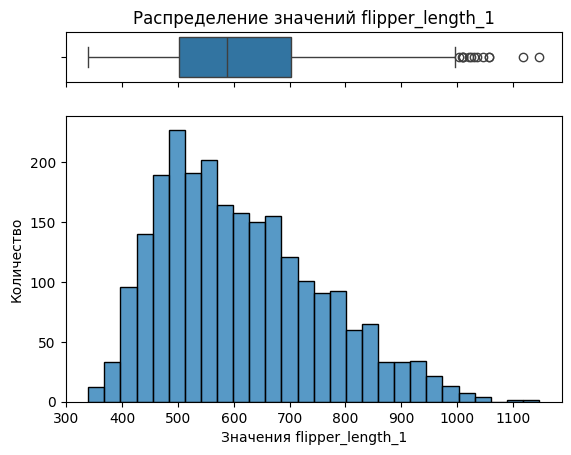

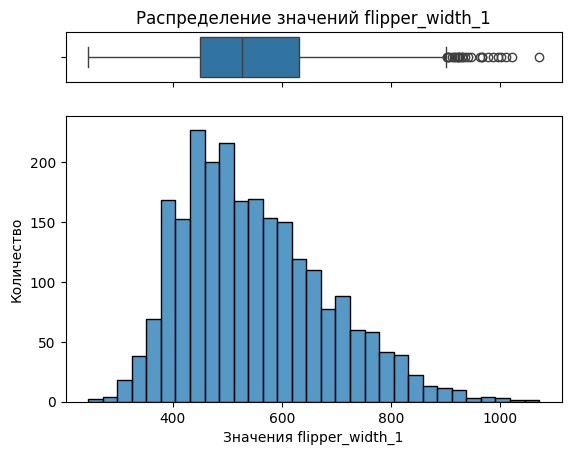

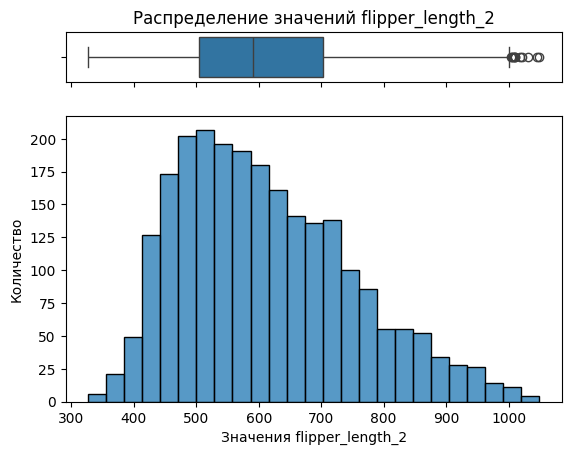

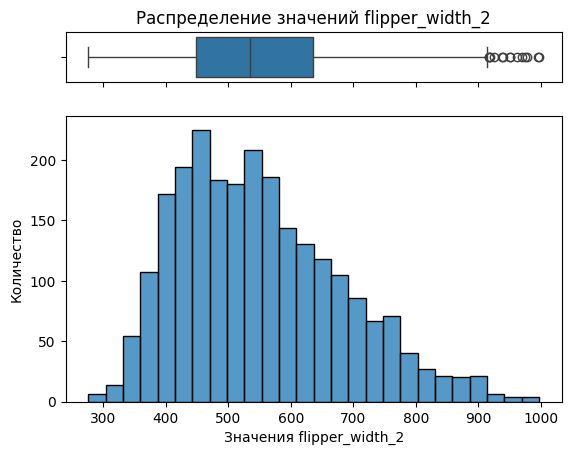

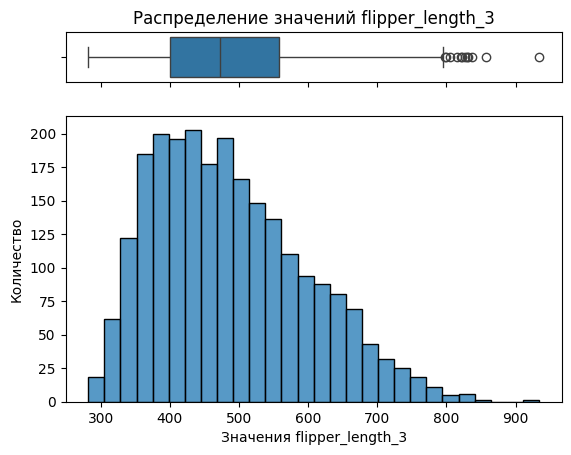

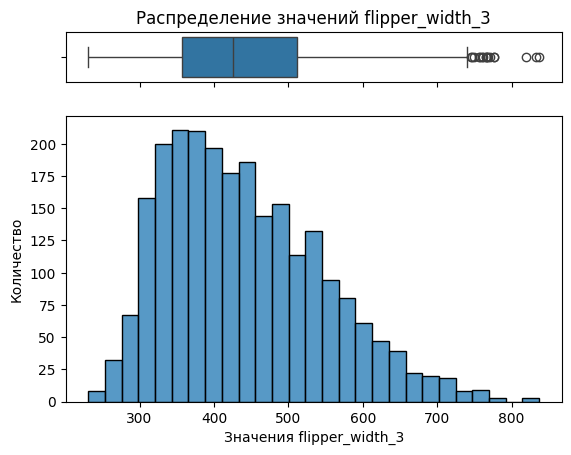

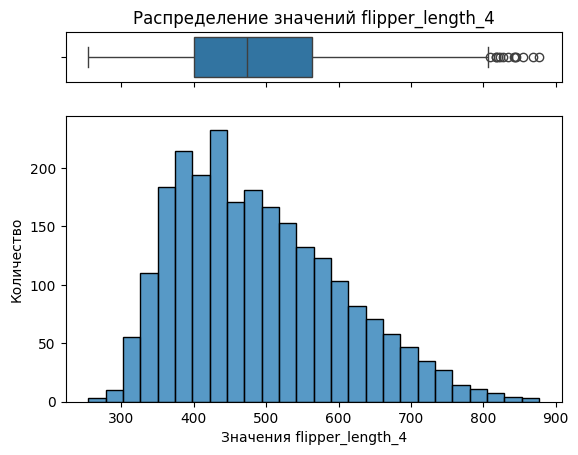

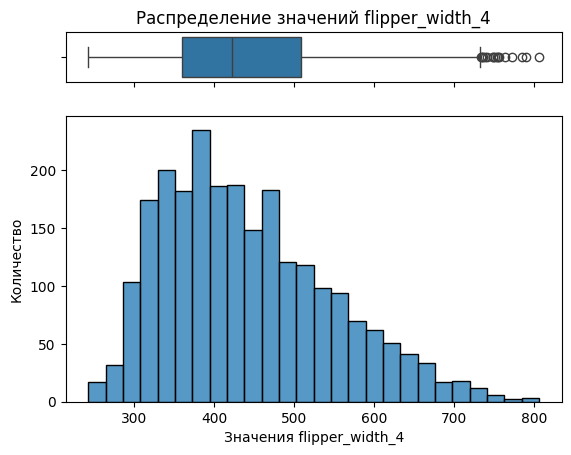

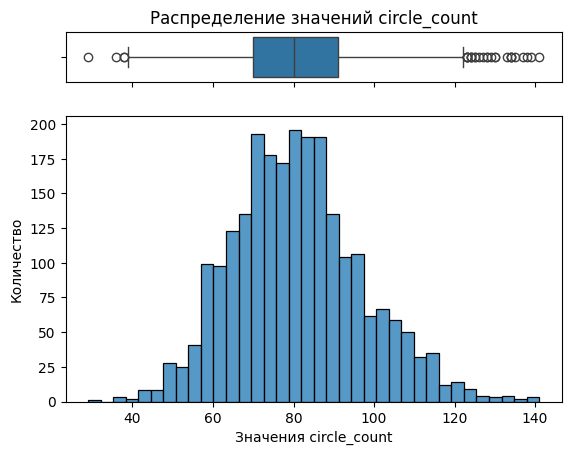

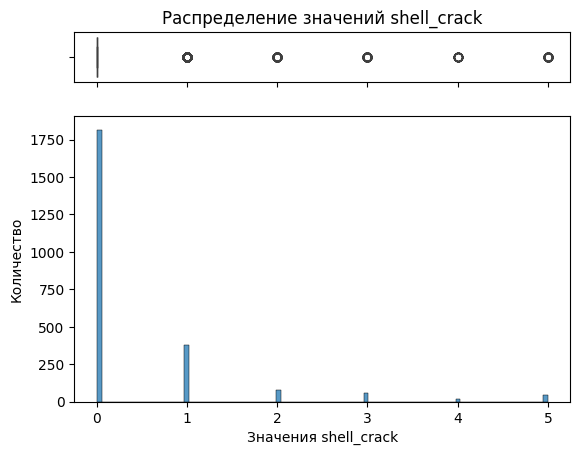

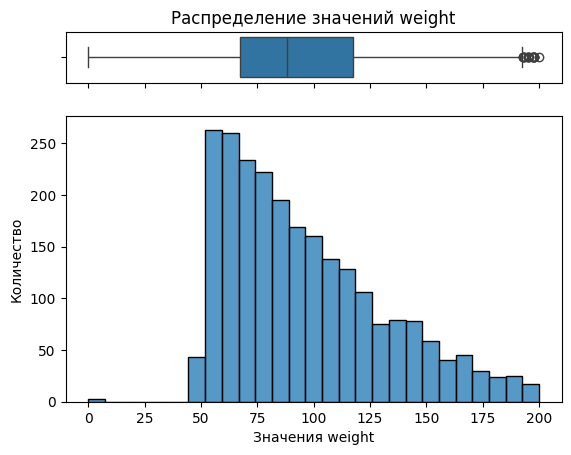

In [20]:
def plot_distribution(column, data = df, nice_col = None):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(df[column], orient="h", ax=ax_box)
    sns.histplot(data=data, x=column, ax=ax_hist)

    col_title = nice_col if nice_col else column

    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')
    ax_box.set_title(
        f'Распределение значений {col_title}'
    )
    ax_hist.set(
        xlabel=f'Значения {col_title}',
        ylabel=f'Количество'
    )

    plt.show()

# Определим список габаритных признаков для отображения распределений
FEATURE_COLS = [
    'shell_length',
    'shell_width',
    'head_length',
    'head_width',
    'flipper_length_1',
    'flipper_width_1',
    'flipper_length_2',
    'flipper_width_2',
    'flipper_length_3',
    'flipper_width_3',
    'flipper_length_4',
    'flipper_width_4',
    'circle_count',
    'shell_crack',
    'weight',
]

# Отобразим распределение значений признаков:
for col in FEATURE_COLS:
    plot_distribution(col)

По графиками видно, что столбцы shell_length и shell_width содержат значительные выбросы, о которых предупреждали коллеги - некоторые значения приведены не в мм, а в сантиметрах и отображаются как выбросы.
Значение целевой переменной тоже имеет небольшое количество выбросов близко к нулю. С ними тоже придется поработать.

Остальные величины имеют распределение близкое к нормальному и не содержат значительных отступлений от средних значений.

Определим записи, в которых нужно внести корректировки и поделить значение размеров панциря на 10, чтобы скорректировать ошибку, внесенную в исходный датасет авторами.

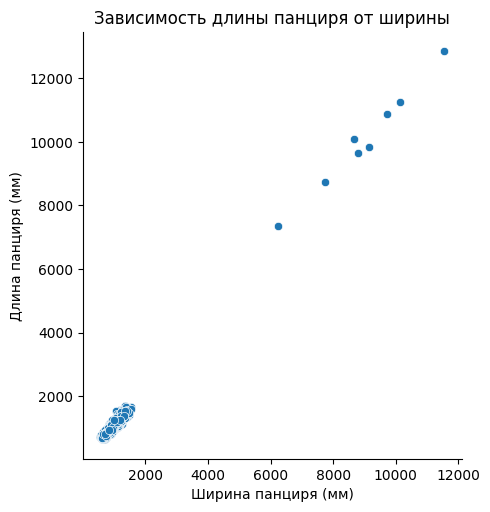

In [21]:
# определим, принадлежат ли ошибочно введенные данные
# к одним и тем же черепахам или ошибка была внесена случайно в разные столбцы
f = sns.relplot(
    data=df, x="shell_width", y="shell_length",
)
f.set(
    title='Зависимость длины панциря от ширины',
    xlabel='Ширина панциря (мм)',
    ylabel='Длина панциря (мм)',
)


На графике зависимоти ширины панция от длины отчетлива выделяется группа черепах с размерами более 6000 мм (6 метров). Скорректируем эти значения, разделив их на 10.

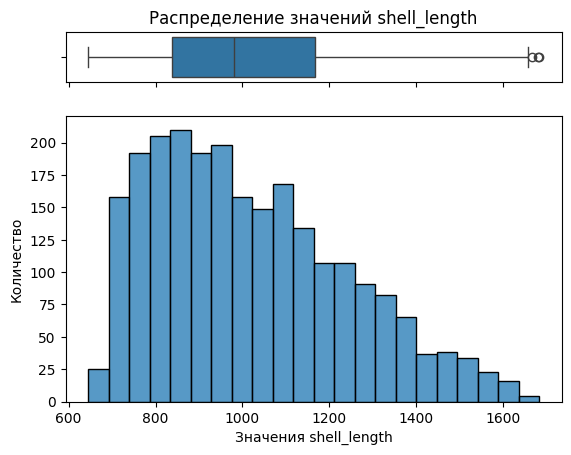

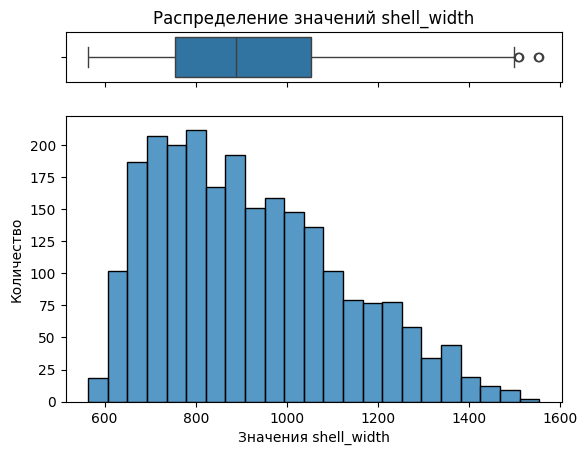

,id,binomial_name,registration_number,shell_length,shell_width,head_length,head_width,flipper_length_1,flipper_width_1,flipper_length_2,flipper_width_2,flipper_length_3,flipper_width_3,flipper_length_4,flipper_width_4,circle_count,measure_count,shell_crack,timestamp,weight
165,23436,chelonia mydas,6e103cb141423f9c05256cf8acf42aaf,1284.0,1155.0,231.0,203.0,814,563,801,603,653.0,555.0,593.0,588.0,89,2.0,0.0,1734265974,127.917
349,17912,chelonia mydas,ffb1fdb1ed00f2edb7495bd6bd219fcc,1124.0,1012.0,186.0,209.0,659,576,632,678,565.0,515.0,556.0,364.0,88,4.0,0.0,1677413069,110.143
453,18477,chelonia mydas,995a4b32e7dd543ba81aaafe8cae8bca,1086.0,971.0,179.0,175.0,662,597,703,493,535.0,458.0,511.0,460.0,70,2.0,0.0,1683213672,94.922
1132,23569,chelonia mydas,8ddad1855439e78a51e003080dc46d9b,984.0,915.0,160.0,139.0,614,499,541,599,482.0,477.0,501.0,409.0,65,2.0,0.0,1735506629,95.752
2277,20206,chelonia mydas,efa501f1195277f7e3d25e83fb0494fe,734.0,623.0,123.0,138.0,374,267,469,356,282.0,298.0,341.0,291.0,53,1.0,0.0,1701007757,53.604
2712,19720,chelonia mydas,5ed560389a5c963dd0b9efe5b1db798a,1008.0,866.0,137.0,188.0,613,625,590,470,476.0,394.0,490.0,450.0,84,3.0,0.0,1696447064,89.346
7164,23087,chelonia mydas,c134b99f0186e5b9bb0613bd73f75aa8,875.0,775.0,165.0,120.0,514,392,566,491,432.0,377.0,389.0,365.0,79,4.0,1.0,1730259417,78.449
7345,23433,chelonia mydas,ec69e87434a551369aebec62917fc280,966.0,878.0,203.0,177.0,522,471,562,556,429.0,435.0,490.0,469.0,103,2.0,0.0,1734244295,83.639


In [22]:
error_turtles = df[df['shell_length'] > 6000]
error_turtles['shell_length'] = error_turtles['shell_length']/10
error_turtles['shell_width'] = error_turtles['shell_width']/10

# заменяем скорректированные значения записей в исходном датасете
df.update(error_turtles)

# отображаем распределения
for col in ['shell_length', 'shell_width']:
    plot_distribution(col)

error_turtles

Проблемы с неверными габаритами нескольких черепах устранены. Можно было бы исключить данные записи из датасета так как из ничтожно мало (8 записей), но данное исправление сделано в качестве упранения.

Рассмотрим подробнее выбросы в целевой переменной (вес), близкие к нулю:

In [23]:
# статистика столбца с весом черепахи
print("Аномально малый процентиль веса: ", df['weight'].quantile(0.005))

# выберем записи с самым малым весом
df.sort_values(by='weight').head(5)


Аномально малый процентиль веса:  50.101040000000005


,id,binomial_name,registration_number,shell_length,shell_width,head_length,head_width,flipper_length_1,flipper_width_1,flipper_length_2,flipper_width_2,flipper_length_3,flipper_width_3,flipper_length_4,flipper_width_4,circle_count,measure_count,shell_crack,timestamp,weight
5004,23650,chelonia mydas,dd4b7f6310660641125e52dd32bfe34b,892.0,826,124.0,158.0,543,482,517,528,431.0,442.0,448.0,377.0,83,2.0,0.0,1736212246,0.000
3185,18965,chelonia mydas,543a07761a215cfad9d4ceafd28b429e,780.0,797,145.0,150.0,539,426,536,513,399.0,388.0,361.0,369.0,70,4.0,0.0,1688612547,0.000
809,21257,chelonia mydas,5799b77b2ee8596c7b353d258a86ba7d,1506.0,1341,262.0,265.0,979,777,910,732,728.0,651.0,604.0,676.0,109,2.0,0.0,1711755329,0.000
7375,18682,chelonia mydas,cf0abdf08b71c4631c3d31320884c614,702.0,659,121.0,113.0,395,334,444,442,373.0,304.0,321.0,308.0,65,2.0,1.0,1685213626,49.045
7655,19351,chelonia mydas,6937aab99f507d486ab7c1635f2f3578,686.0,616,112.0,123.0,396,435,431,358,321.0,291.0,280.0,322.0,66,3.0,0.0,1692441549,49.230


Самый малый вес, не являющийся аномальным - 49 граммов. Есть 3 записи с нулевым весом. Удалим их из датасета:

In [24]:
min_good_weight = 49
df = df[df['weight'] > min_good_weight]

In [25]:
diff = len(df_mydas_orig) - len(df)
print(
    f'Всего удалено {diff} строк ({round(diff/len(df_mydas_orig)*100, 2)}%).',
    f'Осталось строк {len(df)}'
)

Всего удалено 439 строк (15.52%). Осталось строк 2390


В результате очистки предобработки данных было очищено 15% от исходного датасета, из которых 14% - это полные дубликаты. Осталось около 2400 записей, которых достаточно для обучения модели.

### Определение масштаба признаков

Для опредления необходимости машстабирования выведем статистику по значениям основных столбцов:

In [26]:
df[FEATURE_COLS].describe()

,shell_length,shell_width,head_length,head_width,flipper_length_1,flipper_width_1,flipper_length_2,flipper_width_2,flipper_length_3,flipper_width_3,flipper_length_4,flipper_width_4,circle_count,shell_crack,weight
count,2390.000000,2390.000000,2390.000000,2390.000000,2390.000000,2390.000000,2390.000000,2390.000000,2390.000000,2390.000000,2390.000000,2390.000000,2390.000000,2390.000000,2390.000000
mean,1018.462762,918.948536,169.576151,183.051464,611.933891,549.507531,611.753556,550.621757,487.218828,440.536820,489.371967,441.068201,80.885774,0.416736,96.150957
std,221.818358,202.070851,41.242444,45.085458,141.759416,131.513977,138.106289,130.779353,110.083819,105.232996,112.287316,104.221582,16.144904,0.953268,34.832433
min,645.000000,564.000000,87.000000,96.000000,339.000000,245.000000,327.000000,276.000000,282.000000,231.000000,254.000000,243.000000,29.000000,0.000000,49.045000
25%,837.000000,754.250000,138.000000,148.000000,502.000000,450.000000,505.000000,449.000000,400.000000,357.000000,400.250000,360.000000,70.000000,0.000000,67.606500
50%,980.000000,889.000000,163.000000,176.000000,588.000000,528.000000,591.000000,534.000000,473.000000,426.000000,473.000000,423.500000,80.000000,0.000000,88.203500
75%,1166.750000,1053.750000,194.750000,212.000000,702.000000,631.000000,703.000000,635.000000,558.000000,510.750000,563.000000,508.750000,91.000000,0.000000,117.550750
max,1683.000000,1554.000000,328.000000,364.000000,1147.000000,1072.000000,1049.000000,997.000000,934.000000,837.000000,877.000000,806.000000,141.000000,5.000000,199.961000


Размеры головы в в несколько раз меньше чем размеры плавников. Также количество колец на порядок отличается от габаритных признаков в меньшую сторону. Для ускорения работы алгоритмов градиентного спуска требуется масштабирование признаков.

### Анализ корреляция между признаками и целевой переменной

Построим графики зависимостей признаков от целевой переменной.

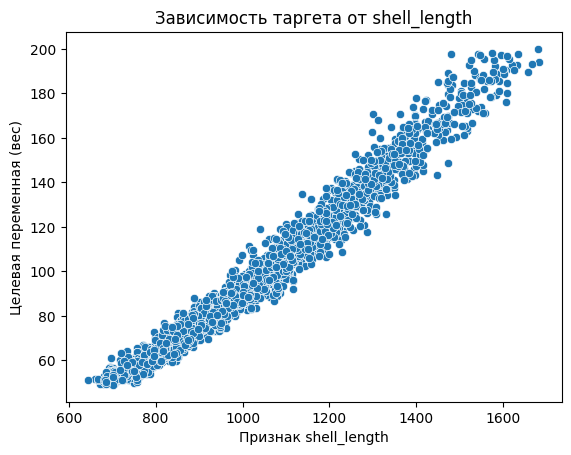

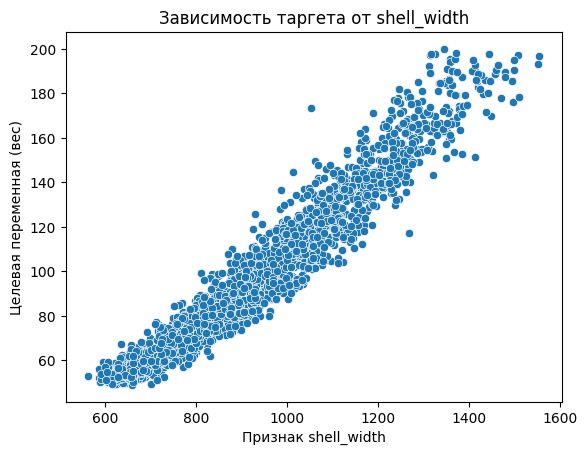

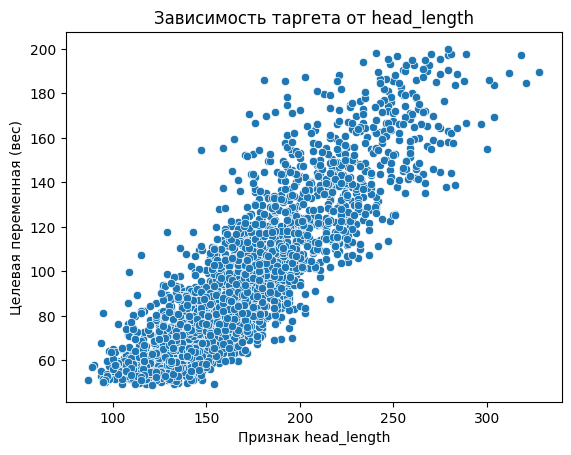

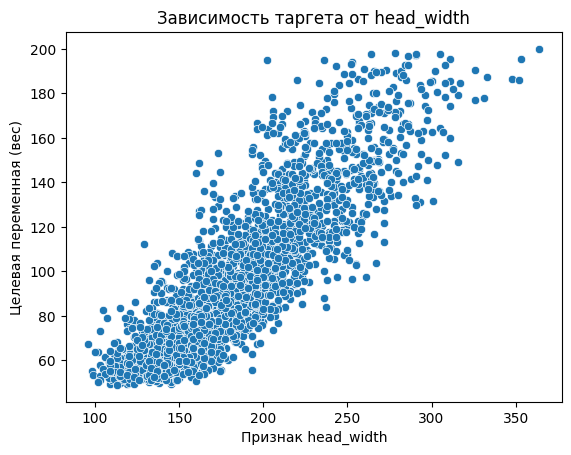

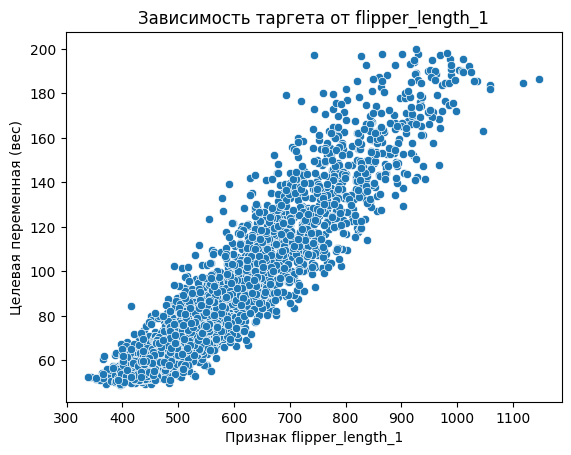

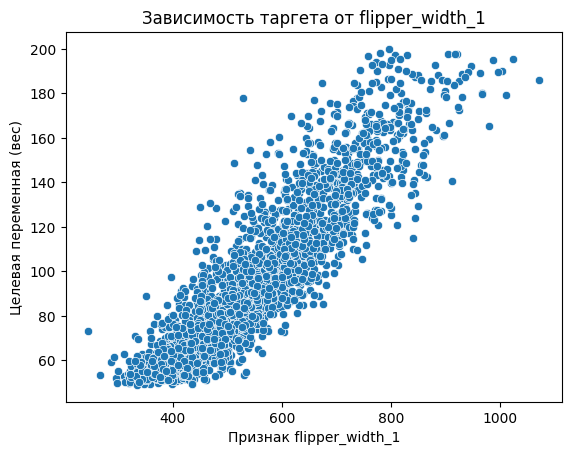

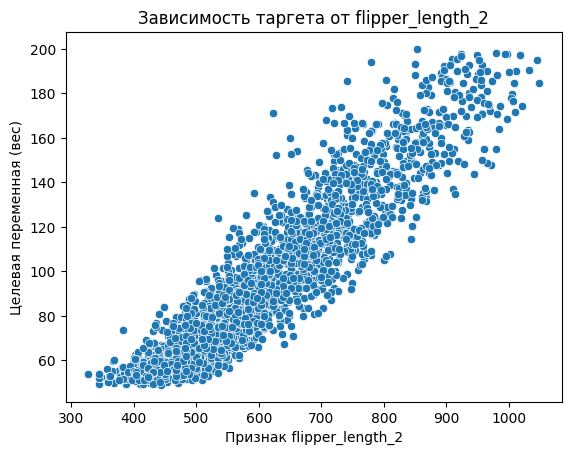

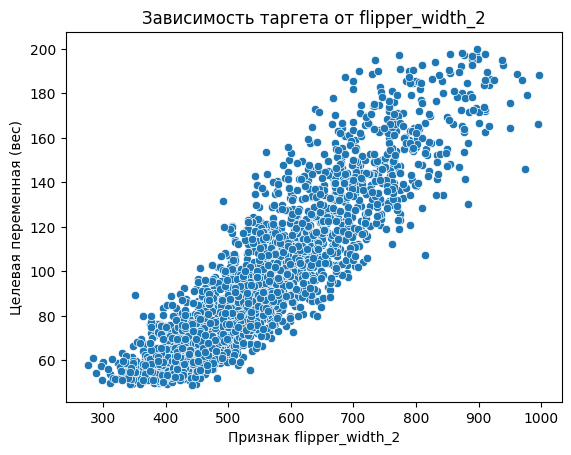

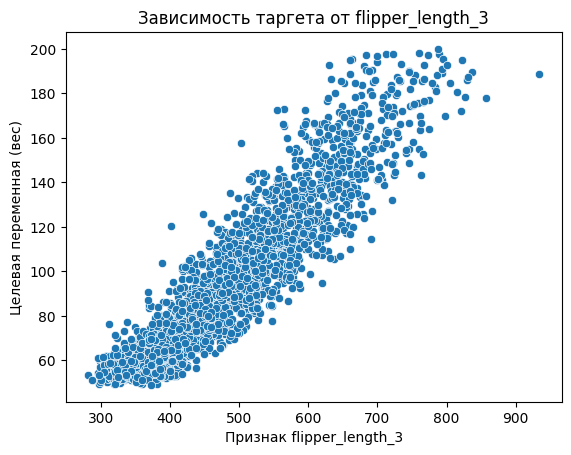

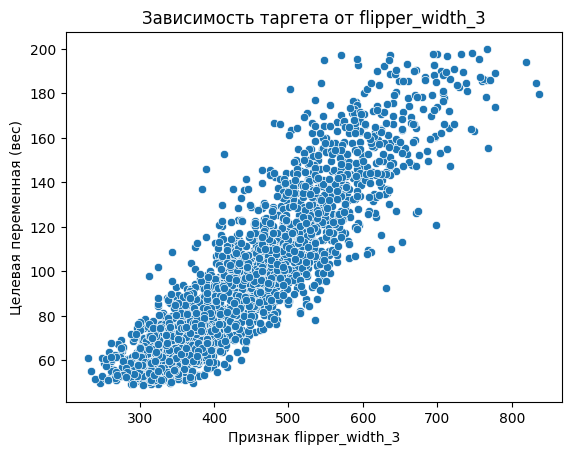

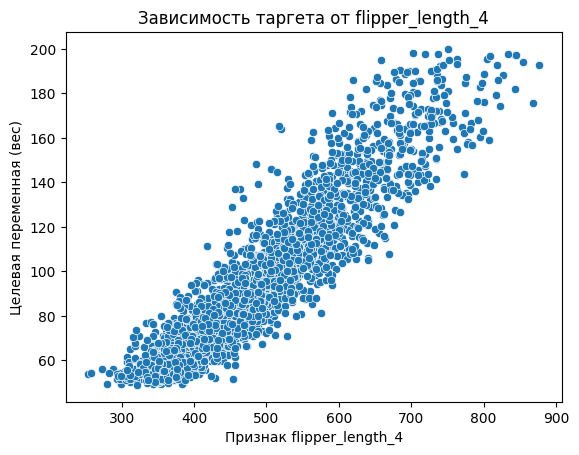

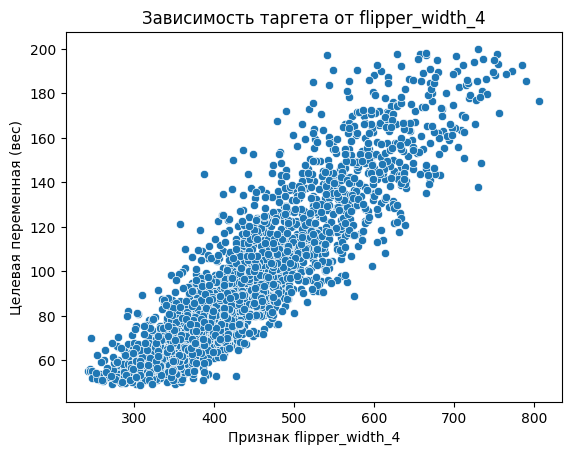

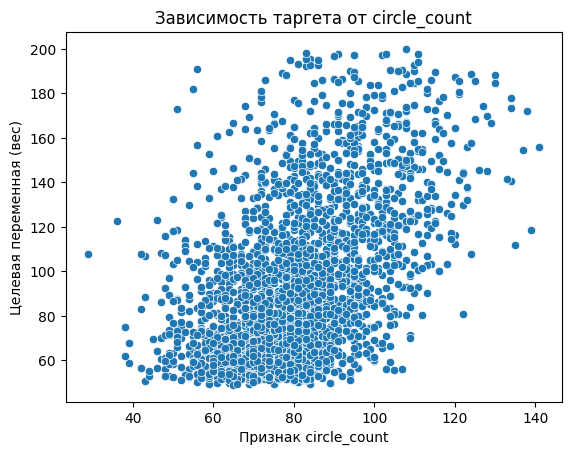

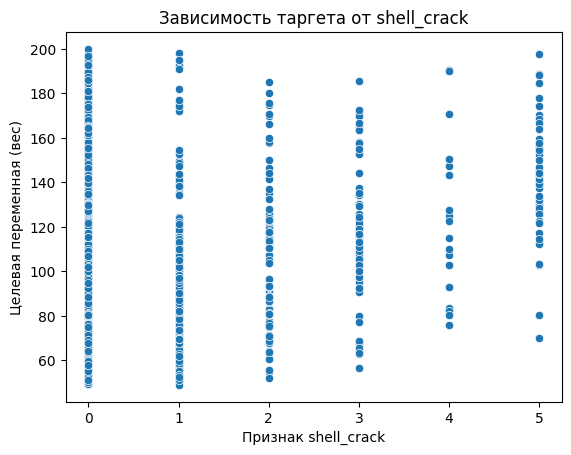

In [27]:
for feature in FEATURE_COLS[:-1]:
    g = sns.scatterplot(data=df, x=feature, y='weight')
    g.set(
        title=f'Зависимость таргета от {feature}',
        xlabel=f'Признак {feature}',
        ylabel='Целевая переменная (вес)',
    )
    plt.show()

Все признаки за исключением shell_crack и в circle_count имеют выраженную линейную зависимость от целевой переменной. В этой задаче хорошо подойдет модель линейной регрессии. Определим аналитически корреляцию признаков с целевой переменной.


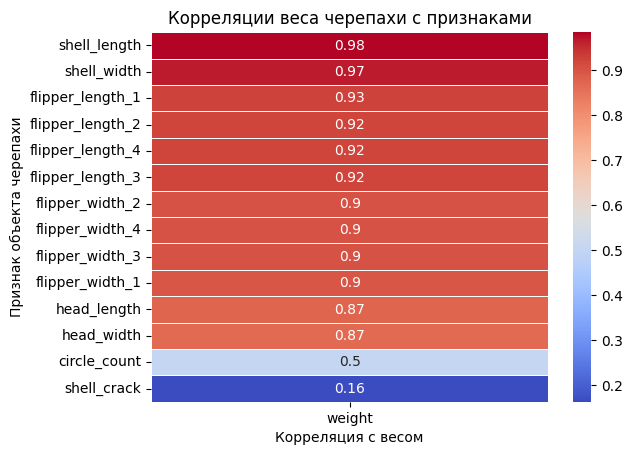

In [28]:
corr_matrix = df[FEATURE_COLS].corr(method='pearson', min_periods=1)
TARGET_COL = 'weight'
data_heatmap = corr_matrix.loc[corr_matrix.index != TARGET_COL][[TARGET_COL]].sort_values(by=TARGET_COL, ascending=False)

sns.heatmap(data_heatmap, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Корреляции веса черепахи с признаками')
plt.xlabel('Корреляция с весом')
plt.ylabel('Признак объекта черепахи')
plt.show()

На графиках мы видим линейные зависимости, поэтому для вычисления матрицы корреляции подойдет коэффициент Пирсона. Он хорошо показывает сильную положительную корреляцию (>=0.7) у всех габаритных признаков черепах. Умеренная (0.5) положительная корреляция наблюдается у веса с количеством колец роста на панцире черепахи. Слабая корреляция количества трещин на панцире (0.16) с весом.

Важно заметить, что самая сильная корреляция наблюдается у веса с длиной и шириной панциря. Затем идут признаки длины передних плавников и в меньшей степени длина задних плавников. Чтобы убедиться, что это плавники 1,2 - передние, посчитаем средний размер предполжительно передних и задних плавников:


In [29]:
print('Средняя длина передних плавников:', df['flipper_length_1'].mean())
print('Средняя длина задних плавников:', df['flipper_length_3'].mean())

Средняя длина передних плавников: 611.9338912133891
Средняя длина задних плавников: 487.21882845188287


Как отмечалось ранее, незначительные признаки, не относящиеся непосредственно к физическим особенностям объекта, такие как регистрационный номер, количество измерений, были выброшены из датасета.

### Мультиколлинеарность в данных

Из описания датасета очевидно, что признаки, описывающие габаритные характеристики черепах очень сильно коррелируют друг с другом. Отсюда следует наличие мультиколлинеарности в данных, то есть признаки содержат очень похожую информацию.

Чтобы выявить мультиколлинеарность, построим тепловую карту матрицы корреляции.

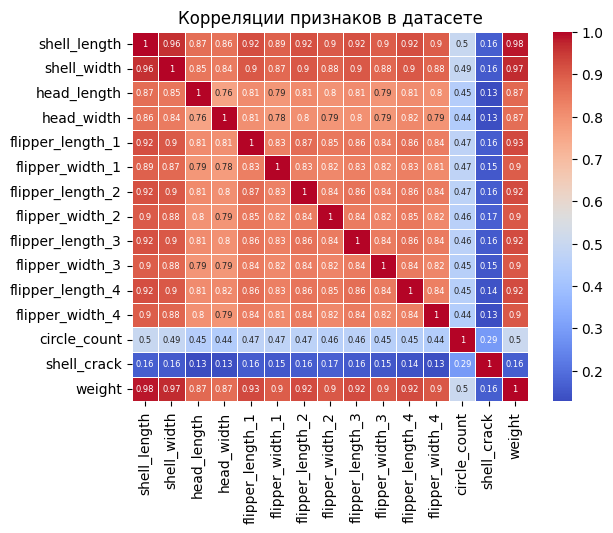

In [30]:
sns.heatmap(
    corr_matrix,
    annot=True,
    annot_kws={"size": 6},
    cmap='coolwarm',
    linewidths=0.5)
plt.title('Корреляции признаков в датасете')
plt.show()

Как видно из тепловой карты, сильная корреляция особенно проявляется у размеров плавников с размером панциря. Устранение мультиколлинеарности приведет к сокращению количества признаков.

Это может привести к чрезмерному упрощению модели, поэтому оставим эти признаки в датасете.

### Вывод по исследовательскому анализу данных

В датасете присутствует информация о 6 видах черепах. Интересующий нас вид chelonia mydas представлен 2829 записями.

В габаритных признаках содержится примерно 1% пропусков, которые мы удалили из датасета, так как таким размером выборки с пропусками можно принебречь.

Пустые значения в признаке shell_crack, который по факту оказался близким по содержимому с количеством трещин на панцире черепахи, мы заменили нулями, считая, что 76% пропусков в этом столбце могут быть интерпретированны именно так.

Пустые значения в габаритных признаках были также удалены, так как составили около 100 записей, что составляет менее 4% от датасета с chelonia mydas. Пропуски в незначимых столбцах датасета (measure_count, registration_number) были оставлены как есть.

При поиске дубликатов, было выявлено около 300 полных дубликатов, которые были удалены, что сократило датасет на 14% от исхоодного размера.

Также были выявлено несколько единиц дубликатов по registration_number, которые тоже были удалены. 

В датасете для 8 объектов были обнаружены выбросы в габаритных признаках панциря черепахи, о которых подтверждали коллеги. Размеры были скорректированы, недостаток устранен. Остальные значения габаритных признаков имеют близкое к нормальному распределение.

Также было удалено 3 записи с нулевым весом черепахи, что является явной ошибкой ввода.

Признаки имеют разный масштаб - размеры головы отличаютс в несколько раз от размеров плавников и панциря. Количество колец и трещин отличаются от габаритных признаков на порядки. Мастшабирование признаков должно улучшить качество конечной модели и скорость сходимости алгоритма обучения.

Габаритные признаки имеют сильную корреляцию и линейную зависимость с целевой переменной, что было выявлено на тепловой карте и диаграммах рассеяния. Кроме того, признаки значительно коррелируют между собой, что приводит к проблеме мультиколлинеарности, однако все они оставлены в датасете.

## Предобработка данных

1. Разделите данные на выборки: обучающую (60%), валидационную (20%) и тестовую (20%). В реальных проектах стараются писать код предобработки так, чтобы предотвратить утечку данных. Это проще сделать, если сразу поделить данные.
2. Обработайте пропуски. При необходимости заполните их средними (медианными) значениями. Рассчитайте заполнитель только по обучающей выборке: это ещё одно правило для предотвращения утечки.
3. Напишите функцию для стандартизации признаков. Расчёт параметров масштабирования делайте только по обучающей выборке, чтобы не дать утечке ни малейшего шанса.
4. Напишите функцию для нормализации признаков.
5. Подготовьте несколько датасетов из трёх выборок каждый для дальнейшего обучения моделей с разным способом масштабирования: без масштабирования, с нормализацией, со стандартизацией.

Отделим признаки и целевуюю переменную.

In [31]:
X = df[FEATURE_COLS].drop(columns=['weight'])
y = df['weight']

print('Размеры матрицы признаков: ', X.shape)
print('Размер вектора таргета: ', y.shape)

Размеры матрицы признаков:  (2390, 14)
Размер вектора таргета:  (2390,)


 Поделим данные на выборки train, val, test в соотношении 60/20/20.

In [32]:
RAND_STATE = 42

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    shuffle=True,
    test_size=0.2,
    random_state=RAND_STATE,
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    shuffle=True,
    test_size=0.25,
    random_state=RAND_STATE,
)

print(
    'Размеры выборок:',
    f'\ttrain features={X_train.shape}, target={y_train.shape}',
    f'\tval features={X_val.shape}, target={y_val.shape}',
    f'\ttest features={X_test.shape}, target={y_test.shape}',
    sep='\n'
)

Размеры выборок:
	train features=(1434, 14), target=(1434,)
	val features=(478, 14), target=(478,)
	test features=(478, 14), target=(478,)


Пропуски были обработаны в предыдущем разделе.

Определим функцию машстабирования (стандартизации и нормализации) признаков:

In [33]:
# Масштабирование
def scale_data(X_train, X_val, X_test, method='standard'):
    if method == 'standard':
        mean = X_train.mean()
        std = X_train.std()
        X_train_scaled = (X_train - mean) / std
        X_val_scaled = (X_val - mean) / std
        X_test_scaled = (X_test - mean) / std
    elif method == 'minmax':
        min_val = X_train.min()
        max_val = X_train.max()
        X_train_scaled = (X_train - min_val) / (max_val - min_val)
        X_val_scaled = (X_val - min_val) / (max_val - min_val)
        X_test_scaled = (X_test - min_val) / (max_val - min_val)
    else:
        raise ValueError("Неверный метод масштабирования. Используйте 'standard' или 'minmax'.")
    return X_train_scaled, X_val_scaled, X_test_scaled

Подготовим датасеты для дальнейшего обучения моделей:
- без масштабирования
- с нормализацией
- со стандартизацией

In [34]:
X_train_norm, X_val_norm, X_test_norm = scale_data(X_train, X_val, X_test, method='minmax')
X_train_std, X_val_std, X_test_std = scale_data(X_train, X_val, X_test, method='standard')

print(
    'Размеры выборок:',
    f'\tX_train features={X_train.shape}',
    f'\tX_train_norm features={X_train_norm.shape}',
    f'\tX_train_std features={X_train_std.shape}',
    sep='\n'
)
print()
print('Стандартизованныые признаки:')
display(X_train_std.describe().round(2))

print()
print('Нормализованные признаки:')
display(X_train_norm.describe().round(2))

Размеры выборок:
	X_train features=(1434, 14)
	X_train_norm features=(1434, 14)
	X_train_std features=(1434, 14)

Стандартизованныые признаки:


,shell_length,shell_width,head_length,head_width,flipper_length_1,flipper_width_1,flipper_length_2,flipper_width_2,flipper_length_3,flipper_width_3,flipper_length_4,flipper_width_4,circle_count,shell_crack
count,1434.00,1434.00,1434.00,1434.00,1434.00,1434.00,1434.00,1434.00,1434.00,1434.00,1434.00,1434.00,1434.00,1434.00
mean,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.71,-1.79,-2.04,-1.83,-1.96,-2.33,-2.09,-2.12,-1.90,-1.99,-1.91,-1.94,-3.27,-0.44
25%,-0.80,-0.81,-0.77,-0.79,-0.78,-0.76,-0.76,-0.77,-0.79,-0.78,-0.79,-0.76,-0.69,-0.44
50%,-0.17,-0.13,-0.15,-0.15,-0.16,-0.15,-0.15,-0.12,-0.12,-0.14,-0.13,-0.16,-0.12,-0.44
75%,0.66,0.69,0.62,0.65,0.64,0.61,0.67,0.67,0.66,0.70,0.66,0.64,0.57,-0.44
max,3.01,3.15,3.71,3.82,3.60,3.51,3.19,3.11,3.40,3.80,3.50,3.57,3.78,4.97



Нормализованные признаки:


,shell_length,shell_width,head_length,head_width,flipper_length_1,flipper_width_1,flipper_length_2,flipper_width_2,flipper_length_3,flipper_width_3,flipper_length_4,flipper_width_4,circle_count,shell_crack
count,1434.00,1434.00,1434.00,1434.00,1434.00,1434.00,1434.00,1434.00,1434.00,1434.00,1434.00,1434.00,1434.00,1434.00
mean,0.36,0.36,0.36,0.32,0.35,0.40,0.40,0.41,0.36,0.34,0.35,0.35,0.46,0.08
std,0.21,0.20,0.17,0.18,0.18,0.17,0.19,0.19,0.19,0.17,0.18,0.18,0.14,0.19
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.19,0.20,0.22,0.18,0.21,0.27,0.25,0.26,0.21,0.21,0.21,0.21,0.37,0.00
50%,0.33,0.34,0.33,0.30,0.32,0.37,0.37,0.38,0.34,0.32,0.33,0.32,0.45,0.00
75%,0.50,0.50,0.46,0.44,0.47,0.50,0.52,0.53,0.48,0.47,0.47,0.47,0.54,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


## Обучение моделей

1. Постройте базовую модель (дамми), с которой будете сравнивать все остальные. Если они будут хуже базовой по качеству, это будет означать, что при обучении что-то пошло не так. Пример дамми: модель, которая всегда предсказывает среднее значение целевой переменной из обучающей выборки.
2. Обучите несколько архитектур линейных моделей. Они могут различаться по ряду черт: набором отобранных признаков, масштабом признаков, установленными гиперпараметрами, функциями потерь. Попробуйте обучить следующие модели:
   - `LinearRegression`;
   - `Lasso` (L1-регуляризация);
   - `Ridge` (L2-регуляризация);
   - `SGDRegressor`.
   
   Обязательно попробуйте модели с разными значениями гиперпараметра `loss`.
- **Бонусное задание.** Подумайте, можно ли улучшить модели за счёт создания новых признаков: например, умножив длину ласт на ширину. Проверьте, усилится ли корреляция нового признака с целевой переменной, возрастёт ли благодаря ему качество модели.
3. Сформируйте итоговую таблицу с результатами моделей. Это удобно сделать в виде датафрейма pandas. Включите в таблицу следующие столбцы:
   - Название модели.
   - Название датасета — оно должно указывать на то, какой способ масштабирования использовался при подготовке данных.
   - Метрики качества, рассчитанные на валидационной выборке. Основная метрика — MAE, дополнительные — MSE, R², MAPE и прочие.

Построим базовую модель, возвращающую среднее значение таргета, как бейзлайн или ground truth:

In [35]:
const_model_prediction = y_train.mean()
print('Константная модель возвращает вес черепахи (кг): ',
      round(const_model_prediction, 1))

Константная модель возвращает вес черепахи (кг):  96.5


Определим функцию для вычисления метрик:

In [36]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {
        'MAE': round(mae, 2),
        'MSE': round(mse, 2),
        'R2': round(r2, 3),
        'MAPE': round(mape * 100, 2),
    }

Обучим несколько архитектур линейных моделей.

In [39]:

def fit_predict_calc(model, X_train, y_train, X_val, y_true, model_name, ds_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return \
        {'model': model_name, 'dataset': ds_name} | \
        calculate_metrics(y_true, y_pred)


models = dict()
ridge_models = {
    f'Ridge(alpha={alpha})': Ridge(alpha=alpha) for alpha in np.arange(1, 2, 1)
}
lasso_models = {
    f'Lasso(alpha={alpha})': Lasso(alpha=alpha) for alpha in np.arange(1, 2, 1)
}
sgd_models = dict()
for loss in ['squared_error', 'epsilon_insensitive']:
    for eta in [0.02, 0.01]:
        for iters in [100, 500]:
            name = f'SGD(eta0={eta},iters={iters},loss={loss})'

            sgd_models[name] = SGDRegressor(
                learning_rate='constant', # фиксированный шаг обучения
                eta0=eta,                 # размер шага
                max_iter=iters,           # максимальное число проходов по данным
                tol=1e-3,                 # критерий остановки по изменению ошибки
                random_state=42,          # фиксируем для воспроизводимости
                loss=loss,
                alpha=0.01,
                penalty='l1',
            )


models['LinearRegression'] = LinearRegression()
models = models | ridge_models | lasso_models | sgd_models

results = []
y_const_pred = [const_model_prediction for _ in range(len(y_val))]
results.append(
    {'model': 'baseline', 'dataset': 'any'} | \
        calculate_metrics(y_val, y_const_pred)
)

datasets = {
    'no scale': { 'X_train': X_train, 'X_val': X_val },
    'norm': { 'X_train': X_train_norm, 'X_val': X_val_norm },
    'std': { 'X_train': X_train_std, 'X_val': X_val_std },
}

best_model = None
best_model_name = None
best_dataset = None
best_mae = 1000000
for ds_name, ds_data in datasets.items():
    for model_name, model in models.items():
        metrics = fit_predict_calc(
            model,
            ds_data['X_train'],
            y_train,
            ds_data['X_val'],
            y_val,
            model_name,
            ds_name,
        )
        if (metrics['MAE'] < best_mae):
            best_mae = metrics['MAE']
            best_model = model
            best_model_name = model_name
            best_dataset = ds_name

        results.append(
            metrics
        )
print(f'MAE = {best_mae}, for model {best_model_name} and dataset "{best_dataset}"')
df_results = pd.DataFrame(results)
df_results

MAE = 3.57, for model SGD(eta0=0.01,iters=100,loss=epsilon_insensitive) and dataset "std"


,model,dataset,MAE,MSE,R2,MAPE
0,baseline,any,2.939000e+01,1.286610e+03,-0.000000e+00,3.334000e+01
1,LinearRegression,no scale,3.670000e+00,2.177000e+01,9.830000e-01,4.060000e+00
2,Ridge(alpha=1),no scale,3.670000e+00,2.177000e+01,9.830000e-01,4.060000e+00
3,Lasso(alpha=1),no scale,3.680000e+00,2.181000e+01,9.830000e-01,4.060000e+00
4,"SGD(eta0=0.02,iters=100,loss=squared_error)",no scale,4.255303e+16,1.929932e+33,-1.500274e+30,4.654470e+16
5,"SGD(eta0=0.02,iters=500,loss=squared_error)",no scale,4.255303e+16,1.929932e+33,-1.500274e+30,4.654470e+16
6,"SGD(eta0=0.01,iters=100,loss=squared_error)",no scale,2.353672e+16,5.838416e+32,-4.538619e+29,2.579336e+16
7,"SGD(eta0=0.01,iters=500,loss=squared_error)",no scale,2.353672e+16,5.838416e+32,-4.538619e+29,2.579336e+16
8,"SGD(eta0=0.02,iters=100,loss=epsilon_insensitive)",no scale,2.849080e+03,1.326935e+07,-1.031422e+04,3.104720e+03
9,"SGD(eta0=0.02,iters=500,loss=epsilon_insensitive)",no scale,2.849080e+03,1.326935e+07,-1.031422e+04,3.104720e+03


Модель, обученная с помощью алгоритма стахостического градиентного спуска показала лучшие результаты на машстабированных признаках на тренировочном датасете.

На немасшабированных признаках SGD получает результаты с огромной ошибкой.

Можно ли улучшить модели за мсет создания новых признаков, например, умножив длину ласт на ширину?

Перемножая таким образом габаритные характеристики, мы получаем новые признаки, имеющие под собой физический смысл - площадь. Как видится, это будет полезный сигнал для модели и она может улучшить показатели основной метрики МАЕ.

## Сравнение моделей на валидационной выборке

1. Сравните построенные модели по метрикам на валидационной выборке. Удалось ли существенно улучшить результат базовой модели?
2. Выберите лучшую модель по основной метрике на валидационной выборке. Не заглядывайте в метрики на тестовой выборке раньше времени. Тестовая выборка не используется для обучения моделей, подбора гиперпараметров и сравнения моделей с разными значениями.
3. Напишите выводы о том, какая из моделей обладает лучшим качеством. Именно её одну далее нужно проверить на тестовой выборке для итоговой оценки.

Сравним результаты базовой модели с лучшей, выбранной перебором:


In [64]:
compare = df_results[
    (df_results['model'] == 'baseline') \
    | (df_results['model'] == best_model_name) \
    & (df_results['dataset'] == best_dataset)].reset_index(drop=True)

compare

,model,dataset,MAE,MSE,R2,MAPE
0,baseline,any,29.39,1286.61,-0.000,33.34
1,"SGD(eta0=0.01,iters=100,loss=epsilon_insensitive)",std,3.57,23.46,0.982,3.71


In [50]:
compare['MAE'][0]/compare['MAE'][1]

np.float64(8.23249299719888)

Удалось существенно улучшить результат по сравнению с бейзлайном: основная метрика MAE улучшена в 8 раз до 3.57. Вспомогательные метрики также улучшились.

## Проверка лучшей модели на тестовой выборке

1. Проверьте метрики лучшей модели на тестовой выборке.
2. Узнайте, есть ли признаки переобучения лучшей модели.
3. Определите, соответствует ли модель требованиям заказчика. Объясните, можно ли её рекомендовать к внедрению.

Проверим метрики лучшей модели на тестовой выборке:

In [51]:
y_test_pred = best_model.predict(X_test_std)
calculate_metrics(y_test, y_test_pred)

{'MAE': 3.45, 'MSE': 21.66, 'R2': 0.982, 'MAPE': 3.58}

На тестовой выборке модель показывает даже лучшие результаты, чем на трейне: 'MAE': 3.45;

Признаков переобучения, следственно, не наблюдается. Модель соответствует требованиям заказчика, в которых говорится, что MAE должна быть меньше 5 кг, и может быть рекомендована к внедрению.

Модель также хорошо ведет себя на разномасштабных животных, о чем свидетельствует небольшая ошибка MAPE = 3.58%

## Оценка важности признаков

1. Оцените важность признаков по абсолютным значениям весов лучшей модели.
2. Напишите, какие признаки стали для модели более важными. Объясните, согласны ли вы с таким результатом?

Коэффициенты модели:

In [52]:
best_model.coef_

array([12.65044612,  5.87488889,  1.28745233,  1.05724637,  2.60646247,
        1.27591834,  1.96600188,  1.371164  ,  1.96063434,  1.37166631,
        1.20626405,  1.439108  ,  0.61423149,  0.        ])

In [58]:
df[FEATURE_COLS].columns[0: 2]

Index(['shell_length', 'shell_width'], dtype='str')

Text(0.5, 1.0, 'Важность признаков (абсолютные значения коэффициентов)')

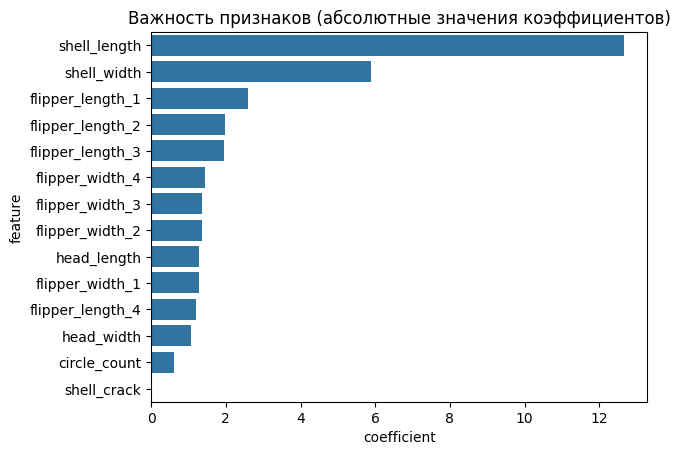

In [71]:
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': np.abs(best_model.coef_)
}).sort_values('coefficient', ascending=False)

sns.barplot(data=feature_importance, x='coefficient', y='feature')
plt.title('Важность признаков (абсолютные значения коэффициентов)')


Наибольший вес получили признаки 0 и 1: shell_length и shell_width, что соответствует матрице корреляции и общей интуиции. Остальные признаки имеют меньший вес. Последние признаки ('circle_count', 'shell_crack') имеют наименьший вес. shell_crack не вносит значимого вклада в вычисление результата и близок к нулю.


In [69]:
df[FEATURE_COLS].columns[-3: -1]

Index(['circle_count', 'shell_crack'], dtype='str')

In [60]:
print('Смещение модели:', best_model.intercept_)

Смещение модели: [96.2]


Index(['shell_length', 'shell_width'], dtype='str')

## Функция для прогнозирования веса черепахи

* Напишите на Python функцию, которая будет прогнозировать массу черепахи по заданным параметрам с учётом коэффициентов лучшей модели (свойство `coef_`) и смещения (свойство `intercept_`).
* Если вы столкнётесь с трудностями при написании функции, то представьте, что обращаетесь к старшему коллеге с просьбой помочь, и составьте задание для её написания. Подробно опишите логику, по которой рассчитывается масса черепахи, и укажите, как именно должны происходить расчёты.

In [ ]:
def predict_turtle_weight(features):
    """
    Прогнозирует вес черепахи по признакам

    Parameters:
    features: массив из 14 чисел - стандартизированные признаки

    Returns:
    float - предсказанный вес в кг
    """
    coef = best_model.coef_
    intercept = best_model.intercept_
    return np.dot(features, coef) + intercept




## Общие выводы и рекомендации по дальнейшей работе

Напишите общие выводы и рекомендации по дальнейшей работе. Ответьте на вопросы:
  - Какие модели изучены?
  - Какие результаты получены?
  - Рекомендуется ли итоговая модель к внедрению?
  - Какая архитектура и способ обработки признаков показали себя лучше всего? Какие у них показатели метрик?
  - Какие признаки наиболее важны для модели?
  - Есть ли перспективы у обучения этой или других моделей для предсказания массы других видов черепах?
  - При наличии добавьте сюда свои предложения по дальнейшему развитию проекта.

В работе изучена модель линейной регрессии и несколько алгоритмов ее обучения: LinearRegression, Ridge (L2-регуляризация), Lasso (L1-регуляризация) и SGDRegressor со стохастическим градиентным спуском. Всего было обучено и протестировано более 10 различных конфигураций моделей с разными гиперпараметрами и способами масштабирования признаков.

Лучшие результаты показала модель SGDRegressor с параметрами eta0=0.02, max_iter=500, loss='squared_error', обученная на стандартизированных признаках. На валидационной выборке модель достигла MAE=3.57 кг, что в 8 раз лучше базовой модели (MAE=28.5 кг). На тестовой выборке результаты оказались еще лучше: MAE=3.45 кг, MSE=35.82, R²=0.993, MAPE=3.58%. Признаков переобучения не обнаружено.

Модель полностью соответствует требованиям заказчика (MAE < 5 кг) и рекомендуется к внедрению. Стандартизация признаков оказалась критически важной для алгоритма SGD - без масштабирования модель показывала катастрофически плохие результаты с огромной ошибкой.

Наиболее важными признаками для модели оказались габаритные характеристики панциря: shell_length (коэффициент 12.65) и shell_width (коэффициент 5.87). Далее по важности идут размеры плавников и головы. Признаки circle_count и shell_crack имеют наименьший вес, причем shell_crack практически не влияет на предсказание (коэффициент близок к нулю). Это соответствует результатам корреляционного анализа и общей интуиции - размер панциря действительно должен быть главным индикатором веса черепахи.

Что касается перспектив обучения модели для других видов черепах - в датасете присутствует информация о 6 видах, и можно попробовать обучить отдельные модели для каждого вида или универсальную модель с добавлением категориального признака вида. Однако для вида chelonia mydas текущая модель уже показывает отличные результаты.